In [1]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer
import evaluate

%matplotlib inline

In [2]:
def read_json_files(dir: str, fname_filter=None) -> list:
    json_fnames = []
    for (_, _, fnames) in os.walk(dir):
        json_fnames.extend(fnames)
        break  # ensure only top level json files are read.

    filter_predicate = lambda name: name.startswith(fname_filter) and name.endswith('.json') if fname_filter else lambda \
            name: name.startswith(filter)
    json_fnames = list(filter(filter_predicate, json_fnames))

    json_data = []
    for fname in json_fnames:
        with open(f'{dir}/{fname}', 'r') as json_file:
            json_data.append(json.load(json_file))
    return json_data


json_data = read_json_files('./data', 'data')

In [3]:
def parse_vantage_api_data(json_data: list) -> pd.DataFrame:
    df_list = []
    for json_dict in json_data:
        for item in json_dict['feed']:
            item_dict = {'title': item['title'], 'time_published': item['time_published'], 'summary': item['summary'],
                         'label': item['overall_sentiment_label'],
                         'score': item['overall_sentiment_score'],
                         'ticker_sentiment': item['ticker_sentiment']}
            df_list.append(item_dict)
    return pd.DataFrame(df_list)


data_df = parse_vantage_api_data(json_data)

In [4]:
data_df.head()

,title,time_published,summary,label,score,ticker_sentiment
0,E-rupee pilot sees trades worth Rs 275 crore o...,20221102T000000,E-rupee pilot sees trades worth Rs 275 crore o...,Somewhat-Bullish,0.201554,"[{'ticker': 'FRBA', 'relevance_score': '0.1228..."
1,Immutep to Participate in Two Upcoming Investo...,20221101T235900,Media Release ...,Neutral,0.079027,"[{'ticker': 'IMMP', 'relevance_score': '0.6154..."
2,"ROSEN, GLOBAL INVESTOR COUNSEL, Encourages Com...",20221101T235800,"NEW YORK, Nov. 01, 2022 ( GLOBE NEWSWIRE ) -- ...",Neutral,0.135679,"[{'ticker': 'META', 'relevance_score': '0.0613..."
3,Michael Khan Joins Pinnacle Bank as Executive ...,20221101T235758,"Pinnacle Bank ( OTCQB: PBNK ) , headquartered ...",Bullish,0.479188,"[{'ticker': 'CAIB', 'relevance_score': '0.1235..."
4,"ANET Stock, NBIX, WMB, MPLX, 7 Other Tickers A...",20221101T235646,IBD stock screens are regularly updated to add...,Bullish,0.414276,"[{'ticker': 'ANET', 'relevance_score': '0.3782..."


In [5]:
data_df["text"] = data_df["title"].str.cat(data_df["summary"])
data_df.head()

,title,time_published,summary,label,score,ticker_sentiment,text
0,E-rupee pilot sees trades worth Rs 275 crore o...,20221102T000000,E-rupee pilot sees trades worth Rs 275 crore o...,Somewhat-Bullish,0.201554,"[{'ticker': 'FRBA', 'relevance_score': '0.1228...",E-rupee pilot sees trades worth Rs 275 crore o...
1,Immutep to Participate in Two Upcoming Investo...,20221101T235900,Media Release ...,Neutral,0.079027,"[{'ticker': 'IMMP', 'relevance_score': '0.6154...",Immutep to Participate in Two Upcoming Investo...
2,"ROSEN, GLOBAL INVESTOR COUNSEL, Encourages Com...",20221101T235800,"NEW YORK, Nov. 01, 2022 ( GLOBE NEWSWIRE ) -- ...",Neutral,0.135679,"[{'ticker': 'META', 'relevance_score': '0.0613...","ROSEN, GLOBAL INVESTOR COUNSEL, Encourages Com..."
3,Michael Khan Joins Pinnacle Bank as Executive ...,20221101T235758,"Pinnacle Bank ( OTCQB: PBNK ) , headquartered ...",Bullish,0.479188,"[{'ticker': 'CAIB', 'relevance_score': '0.1235...",Michael Khan Joins Pinnacle Bank as Executive ...
4,"ANET Stock, NBIX, WMB, MPLX, 7 Other Tickers A...",20221101T235646,IBD stock screens are regularly updated to add...,Bullish,0.414276,"[{'ticker': 'ANET', 'relevance_score': '0.3782...","ANET Stock, NBIX, WMB, MPLX, 7 Other Tickers A..."


In [6]:
# Only 3 labels in finbert
label_map = {
    'Bearish': 0,
    'Somewhat-Bearish': 0,
    'Neutral': 1,
    'Somewhat-Bullish': 2,
    'Bullish': 2,
}

for key in list(label_map.keys()):
    data_df.loc[data_df['label'] == key, 'label'] = label_map[key]

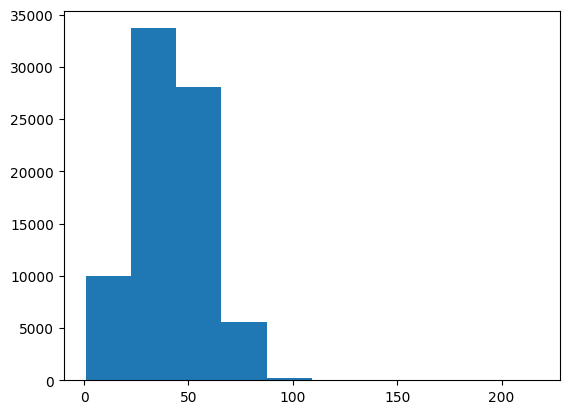

In [7]:
# Length distribution of each summary

text_len_dist = np.asarray([0 if sen is None else len(sen.split()) for sen in data_df['text']])

_ = plt.hist(text_len_dist)

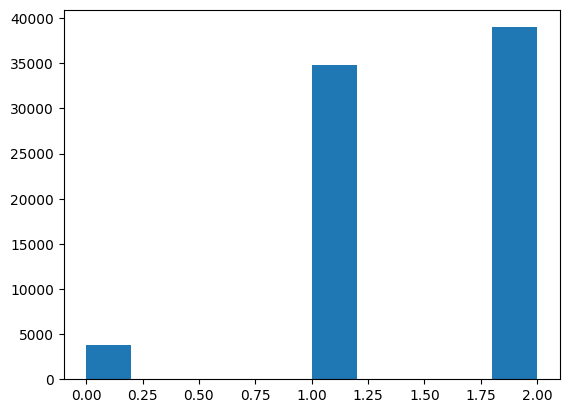

In [8]:
_ = plt.hist(data_df['label'])

In [9]:
from datasets import Dataset, concatenate_datasets

ds = Dataset.from_pandas(data_df[['text', 'label']])

In [10]:
ds

Dataset({
    features: ['text', 'label'],
    num_rows: 77583
})

In [11]:
# Fix class imbalance
ds_bearish = ds.filter(lambda example: example['label'] == 0)
ds_neutral = ds.filter(lambda example: example['label'] == 1)
ds_bullish = ds.filter(lambda example: example['label'] == 2)

print(f'Bearish:{ds_bearish.shape[0]}\nNeutral:{ds_neutral.shape[0]}\nBullish:{ds_bullish.shape[0]}')

Filter:   0%|          | 0/77583 [00:00<?, ? examples/s]

Filter:   0%|          | 0/77583 [00:00<?, ? examples/s]

Filter:   0%|          | 0/77583 [00:00<?, ? examples/s]

Bearish:3840
Neutral:34760
Bullish:38983


In [12]:
ds_neutral = ds_neutral.shuffle().select(range(7000))
ds_bullish = ds_bullish.shuffle().select(range(7000))
ds_sub = concatenate_datasets([ds_bearish, ds_neutral, ds_bullish])
ds_sub = ds_sub.shuffle()

Text(0.5, 1.0, 'Dataset size: 17840')

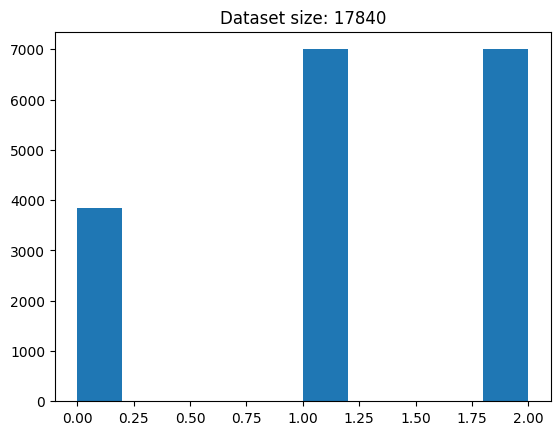

In [13]:
_ = plt.hist(ds_sub['label'])
plt.title(f'Dataset size: {ds_sub.shape[0]}')

Loading Bert model

In [14]:
# MODEL_NAME = "google-bert/bert-base-uncased"
MODEL_NAME = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


def tokenize(datapoint):
    return tokenizer(datapoint['text'], padding='max_length', truncation=True)


tokenized_df = ds_sub.map(tokenize, batched=True)

E:\Academics\NEU\DS5230 - USML\Assignments\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/17840 [00:00<?, ? examples/s]

In [15]:
# train test split
ds = tokenized_df.train_test_split(test_size=0.3, train_size=0.7, shuffle=True)

ds['train']

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 12488
})

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

In [17]:
training_args = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5)

metric = evaluate.load("accuracy")

In [18]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    y_pred = np.argmax(logits, axis=-1)
    return metric.compute(predictions=y_pred, references=labels)

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds['train'],
    eval_dataset=ds['test'],
    compute_metrics=compute_metrics,
)

trainer.train()

E:\Academics\NEU\DS5230 - USML\Assignments\venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.781100,0.716288,0.660874
2,0.529000,0.688469,0.693572
3,0.335500,0.963678,0.680680
4,0.171600,1.410429,0.692825
5,0.106100,1.704914,0.686472


TrainOutput(global_step=3905, training_loss=0.3693568904940206, metrics={'train_runtime': 2625.2161, 'train_samples_per_second': 23.785, 'train_steps_per_second': 1.487, 'total_flos': 1.642880180293632e+16, 'train_loss': 0.3693568904940206, 'epoch': 5.0})